# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [2]:
import napari
from macrohet import dataio, tile, visualise
import os, glob
from tqdm.auto import tqdm
from skimage import io
import numpy as np

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [3]:
%%time
expt_ID = 'ND0002'
# base_dir = f'/mnt/DATA/macrohet/{expt_ID}/'
base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/'
# base_dir = f'/mnt/SYNO/macrohet_syno/ND0002/acquisition/2nd export/ND0002__2023-11-30T17_19_20-Measurement 2'
# metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/Images/Index*xml'))[0]
metadata_fn = '/mnt/SYNO/macrohet_syno/ND0002/acquisition/2nd export/ND0002__2023-11-30T17_19_20-Measurement 2/Images/Index.idx.xml'
metadata = dataio.read_harmony_metadata(metadata_fn)  
# temporary hack to fix URL from incorrectly exported metadata
# metadata['URL'] = metadata.apply(dataio.generate_url, axis=1)
metadata

Reading metadata XML file...


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/SYNO/macrohet_syno/ND0002/acquisition/2nd export/ND0002__2023-11-30T17_19_20-Measurement 2/Images/Index.idx.xml'

### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [ ]:
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*AssayLayout.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

### Define row and column of choice

In [17]:
acq_ID = row, column = (3, 4)

### Define subset if non-square tiling or more than one contiguous region of images in imaging well. 

In [5]:
# subset_field_IDs = ['1','6','7','8','11','12','13','14','15']

### Load images using zarr

In [18]:
import zarr

In [ ]:
images = ..

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [20]:
%%time
# image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
image_dir = os.path.join(base_dir, 'acquisition/Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             # subset_field_IDs=['16', '17',  '20', '21'], 
                             # n_tile_rows = 2, n_tile_cols = 2,
                             set_plane='max_proj',
                             # set_channel=1,
                             # set_time = 1,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()
images

CPU times: user 1.29 s, sys: 17.2 ms, total: 1.31 s
Wall time: 1.42 s


dask.array<max-aggregate, shape=(150, 2, 6048, 6048), dtype=uint16, chunksize=(1, 2, 2160, 2160), chunktype=numpy.ndarray>

In [101]:
%%time
images = images.compute().compute()

CPU times: user 6h 36min 7s, sys: 49min 7s, total: 7h 25min 14s
Wall time: 53min 52s


In [12]:
images.shape

(150, 2, 6048, 6048)

In [102]:
viewer = napari.Viewer(title = f'{expt_ID}')

viewer.add_image(images, channel_axis = 1)

[<Image layer 'Image' at 0x7efe5e23c9a0>,
 <Image layer 'Image [1]' at 0x7ef2b8dfbe20>]

In [103]:
print()

# Trying two channel segmentation

In [104]:
!nvcc --version
!nvidia-smi

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

# model = models.Cellpose(gpu=True, model_type='cyto')
model_path = '/mnt/DATA/macrohet/PS0000/upstream_development/segmentation/cellpose_training/models/macrohet_seg'
model = models.CellposeModel(gpu=True, 
                             pretrained_model=model_path)
def segment(img, diameter = 30, channels = [0,0]):
    masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=channels,
                                             flow_threshold=None, cellprob_threshold=0)
    return masks

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Thu Jan 11 13:30:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:65:00.0  On |                  Off |
| 30%   38C    P8              33W / 300W |   9319MiB / 49140MiB |      4%      D

INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.models:>> cyto << model set to be used
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU


>>> GPU activated? YES


INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


In [36]:
img = images[0]

In [106]:
img.shape

(2, 6048, 6048)

In [130]:
rfp_t0 = img[0]
gfp_t0= img[1]

## 2ch segmentation - default model

In [110]:
model = models.CellposeModel(gpu=True, 
                             model_type='cyto'
                             # pretrained_model=model_path
                            )

INFO:cellpose.models:>> cyto << model set to be used
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


### Create RGB green/red image of 2ch image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [136]:
%%time

# rgb_image = np.zeros((6048, 6048, 3), dtype=img.dtype)

# Assign the first channel of img to the green channel in the RGB image
rgb_image[:, :, 0] = img[0]

# Assign the second channel of img to the red channel in the RGB image
rgb_image[:, :, 1] = img[1]

CPU times: user 2min 29s, sys: 21 s, total: 2min 50s
Wall time: 55.8 s


In [138]:
viewer.add_image(rgb_image)

<Image layer 'rgb_image' at 0x7efff3a09fd0>

In [139]:
%%time
masks, _,_ = model.eval(rgb_image, diameter=None, channels=[2,1],
                                         flow_threshold=0.4, do_3D=False)

CPU times: user 19.4 s, sys: 5.23 s, total: 24.6 s
Wall time: 24.6 s


### Default model of cellpose no way in hell going to work on this

In [140]:
viewer.add_labels(masks)

<Labels layer 'masks' at 0x7ef2b7f48fa0>

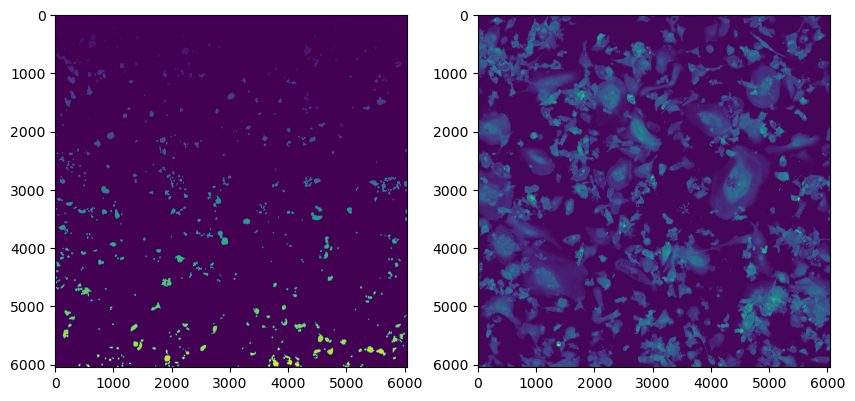

In [141]:
# Plotting the two images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axs[0].imshow(masks)
axs[1].imshow(gfp_t0)

### Trying my previous macrohet cellpose model 

In [150]:
model_path = f'/mnt/DATA/macrohet/PS0000/upstream_development/segmentation/cellpose_training/models'
model_path

'/home/dayn/analysis/models/cellpose/PS0000/macrohet_seg'

In [151]:
model = models.CellposeModel(gpu=True, 
                            pretrained_model=model_path
                            )

INFO:cellpose.models:>>>> loading model /home/dayn/analysis/models/cellpose/PS0000/macrohet_seg
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:>>>> model diam_labels =  188.746 (mean diameter of training ROIs)


In [152]:
viewer.add_image(gfp_t0)

<Image layer 'gfp_t0' at 0x7efe5e527be0>

In [166]:
%%time
masks, _,_ = model.eval(gfp_t0, diameter=None,
                        channels = [0,0],
                        # cellprob_threshold = -3 # didnt do anything noticeable
                        flow_threshold=2.5
                       )

CPU times: user 2min 14s, sys: 51.6 s, total: 3min 5s
Wall time: 2min 1s


In [167]:
viewer.add_labels(masks)

<Labels layer 'masks [2]' at 0x7ef2b8a17d90>

# Testing whole stack

In [19]:
mask_stack = []
for t, frame in tqdm(enumerate(images), total = 150):
    gfp_frame = frame[1]
    masks, _,_ = model.eval(gfp_frame, diameter=None,
                        channels = [0,0]    
                       )
    # save out mask in case kernel crashes 
    t_fn = f'{t}'.zfill(4)
    fn = f'/mnt/DATA/macrohet/{expt_ID}/upstream_development/segmentation/cellpose/{acq_ID}/t{t_fn}_mphi_model_mask.tif'
    io.imsave(fn, masks)
    mask_stack.append(masks)
mask_stack = np.stack(mask_stack, axis = 0)

NameError: name 'images' is not defined

In [ ]:
viewer.add_image(mask_stack)

### Load masks

In [21]:
mask_stack = []
# load masks 
for t, frame in tqdm(enumerate(images), total = 150):
    # gfp_frame = frame[1]
    # masks, _,_ = model.eval(gfp_frame, diameter=None,
    #                     channels = [0,0]    
    #                    )
    # # save out mask in case kernel crashes 
    t_fn = f'{t}'.zfill(4)
    fn = f'/mnt/DATA/macrohet/{expt_ID}/upstream_development/segmentation/cellpose/{acq_ID}/t{t_fn}_mphi_model_mask.tif'
    masks = io.imread(fn)
    mask_stack.append(masks)
segmentation = np.stack(mask_stack, axis = 0)

  0%|          | 0/150 [00:00<?, ?it/s]

In [22]:
viewer = napari.Viewer(title = 'testing tracks')

viewer.add_labels(segmentation)

<Labels layer 'segmentation' at 0x7efc47639760>

# Test track

In [ ]:
def segment(frame, model = model, channels = [0,0], diameter = 0,#325
            min_size = 0 #2500
           ):
    
#     masks, flows, styles, diams = model.eval(frame, 
#                                              channels = channels, 
#                                              diameter = diameter, 
#                                              min_size = min_size, 
#                                              )
    masks, flows, styles = model.eval(frame, 
                                      channels = channels, 
                                      diameter = diameter, 
                                      min_size = min_size, 
                                      )
    return masks


# define features to use for tracking 
features = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "mean_intensity",
    "intensity_image"
    ]

scale_factor = 1/5.04

def localise(masks, intensity_image, properties=tuple(features), use_weighted_centroid = False):
    
    # localise objs in images
    objects = btrack.utils.segmentation_to_objects(segmentation=masks,
                                                   intensity_image=intensity_image, 
                                                   properties=properties,
                                                   scale=(scale_factor,scale_factor),
                                                   use_weighted_centroid=use_weighted_centroid, 
                                                   )
                                                   
    return objects

# define config fn to use, using a prob_not_assign = 0.1
config_fn = '/home/dayn/analysis/btrack/models/particle_config_pnassign.json'

def track(objects, masks, config_fn, search_radius = 20):

    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure(config_fn)
        # set max search radius
        tracker.max_search_radius = search_radius
        # define tracking method
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        # redefine features so that both channels are included in track measurements
        tracker.features = list(objects[0].properties.keys())
        # append the objects to be tracked
        tracker.append(objects)
        # set the tracking volume
        tracker.volume=((0, masks.shape[-2]*scale_factor), (0, masks.shape[-1]*scale_factor))
        # track them (in interactive mode)
        tracker.track(step_size=25)
        # generate hypotheses and run the global optimizer
        tracker.optimize()
        # store the tracks
        tracks = tracker.tracks

    return tracks

In [23]:
import btrack

In [24]:
features = [
  "area",
  "eccentricity",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  # "mean_intensity",
  # "max_intensity", 
  # "min_intensity",
  # "intensity_image"
    ]

In [27]:
intensity_image = np.zeros_like(segmentation)

In [28]:
intensity_image = np.stack([intensity_image, intensity_image, intensity_image], axis = -1)

In [30]:
intensity_image.shape

(150, 6048, 6048, 3)

In [26]:
scale_factor = 1/5.04


((0.1984126984126984, 0.1984126984126984),)

In [27]:
objects = btrack.utils.segmentation_to_objects(segmentation = segmentation, 
                                               # intensity_image = intensity_image, 
                                               properties = tuple(features), 
                                               scale = (scale_factor,scale_factor),
                                               assign_class_ID = True, 
                                               num_workers = 10)

[INFO][2024/01/16 03:35:35 pm] Localizing objects from segmentation...
INFO:btrack.io._localization:Localizing objects from segmentation...
[INFO][2024/01/16 03:35:35 pm] Processing using 10 workers.
INFO:btrack.io._localization:Processing using 10 workers.
[INFO][2024/01/16 03:37:18 pm] Objects are of type: <class 'dict'>
INFO:btrack.io.utils:Objects are of type: <class 'dict'>
[INFO][2024/01/16 03:37:19 pm] ...Found 82620 objects in 150 frames.
INFO:btrack.io._localization:...Found 82620 objects in 150 frames.


In [28]:
objects[0]

{'ID': 0, 'x': 256.86395798063984, 'y': 9.540630290402396, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'area': 10970, 'eccentricity': 0.5528266909714246, 'major_axis_length': 133.04921917267686, 'minor_axis_length': 110.86941615927825, 'orientation': -1.4673923660432366, 'class_id': 1.0}

In [34]:
config_fn = '/home/dayn/analysis/models/btrack/particle_config_pnassign.json'
search_radius = 20

In [35]:
config_fn = '/home/dayn/analysis/models/btrack/particle_config_pnassign.json'

# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
    # configure the tracker using a config file
    tracker.configure(config_fn)
    # set max search radius
    tracker.max_search_radius = search_radius
    # define tracking method
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    # redefine features so that both channels are included in track measurements
    tracker.features = list(objects[0].properties.keys())
    # append the objects to be tracked
    tracker.append(objects)
    # set the tracking volume
    tracker.volume=((0, masks.shape[-2]*scale_factor), (0, masks.shape[-1]*scale_factor))
    # track them (in interactive mode)
    tracker.track(step_size=25)
    # generate hypotheses and run the global optimizer
    tracker.optimize()
    # store the tracks
    tracks = tracker.tracks

[INFO][2024/01/16 03:53:42 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/01/16 03:53:42 pm] Starting BayesianTracker session
INFO:btrack.core:Starting BayesianTracker session
[INFO][2024/01/16 03:53:42 pm] Loading configuration file: /home/dayn/analysis/models/btrack/particle_config_pnassign.json
INFO:btrack.config:Loading configuration file: /home/dayn/analysis/models/btrack/particle_config_pnassign.json
[INFO][2024/01/16 03:53:42 pm] Objects are of type: <class 'list'>
INFO:btrack.io.utils:Objects are of type: <class 'list'>
[INFO][2024/01/16 03:53:44 pm] Starting tracking... 
INFO:btrack.core:Starting tracking... 
[INFO][2024/01/16 03:53:44 pm] Update using: ['MOTION', 'VISUAL']
INFO:btrack.core:Update using: ['MOTION', 'VISUAL']
[INFO][2024/01/16 03:53:45 pm] Tracking objects in frames 0 to 24 (of 150)...
INFO:btrack.core:Tracking objects in frames 0 to 2

GLPK Integer Optimizer 5.0
111556 rows, 1403631 columns, 2751484 non-zeros
1403631 integer variables, all of which are binary
Preprocessing...
55778 rows, 1403631 columns, 2751484 non-zeros
1403631 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 55778
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
55778 rows, 1403631 columns, 2751484 non-zeros
*     0: obj =   3.528421386e+05 inf =   0.000e+00 (1343888)
*   168: obj =   3.519658714e+05 inf =   0.000e+00 (1276856)
*   306: obj =   3.512794924e+05 inf =   0.000e+00 (1207960)
Perturbing LP to avoid stalling [325]...
*   485: obj =   3.503346551e+05 inf =   0.000e+00 (1152828)
*   674: obj =   3.493590383e+05 inf =   0.000e+00 (1037461)
*   882: obj =   3.478861559e+05 inf =   0.000e+00 (986049)
*  1056: obj =   3.470883714e+05 inf =   0.000e+00 (914678)
*  1232: obj = 

[INFO][2024/01/16 04:16:16 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


In [48]:
filtered_tracks = [t for t in tracks if len(t)>15]

In [49]:
napari_tracks, _, _ = btrack.utils.tracks_to_napari(filtered_tracks, ndim = 2)

In [50]:
viewer.add_tracks(napari_tracks, scale = (1/scale_factor,1/scale_factor))

<Tracks layer 'napari_tracks' at 0x7efd6fd51430>

In [55]:
os.path.join(base_dir, f'labels/testing_{row, column}.h5')

'/mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5'

In [56]:
# save out 
with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/testing_{row, column}.h5'), 
                                   'w', 
                                   obj_type='obj_type_1'
                                   ) as writer:
#             writer.write_objects(objects)
        writer.write_tracks(tracks)
        writer.write_segmentation(segmentation)

[INFO][2024/01/16 04:29:13 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4).h5...
[INFO][2024/01/16 04:29:15 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/16 04:29:15 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/16 04:29:15 pm] Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
[INFO][2024/01/16 04:29:17 pm] Writing properties/obj_type_1/area (72361,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/area (72361,)
[INFO][2024/01/16 04:29:17 pm] Writing properties/obj_type_1/eccentricity (72361,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/eccentricity (72361,)
[INFO][2024/01/16 04:29:17 pm] Writing properties/obj_type_1/major_axis_length (72361,)
INFO:btrack.io.hdf:Writing properties/

In [52]:
help(btrack.utils.update_segmentation)

Help on function update_segmentation in module btrack.utils:

update_segmentation(segmentation: 'npt.NDArray', tracks: 'list[btypes.Tracklet]', *, scale: 'Optional[tuple(float)]' = None, color_by: 'str' = 'ID') -> 'npt.NDArray'
    Map tracks back into a masked array.
    
    Parameters
    ----------
    segmentation : npt.NDArray
        Array containing a timeseries of single cell masks. Dimensions should be
        ordered T(Z)YX. Assumes that this is not binary and each object has a unique ID.
    tracks : list[btypes.Tracklet]
        A list of :py:class:`btrack.btypes.Tracklet` objects from BayesianTracker.
    scale : tuple, optional
        A scale for each spatial dimension of the input tracks. Defaults
        to one for all axes, and allows scaling for anisotropic imaging data.
        Dimensions should be ordered XY(Z).
    color_by : str, default = "ID"
        A value to recolor the segmentation by.
    
    Returns
    -------
    relabeled : npt.NDArray
        Array 

In [61]:
recolored_segmentation = btrack.utils.update_segmentation(segmentation, tracks ,scale = (1/scale_factor,1/scale_factor))

In [62]:
viewer.add_labels(recolored_segmentation)

<Labels layer 'recolored_segmentation [1]' at 0x7efd155aef10>

## varying params

In [66]:
import json
import copy

# Original values
original_segmentation_miss_rate = 0.1
original_prob_not_assign = 0.1

# Generate values: 50% less, original, 50% more
segmentation_miss_rates = [0.5 * original_segmentation_miss_rate, original_segmentation_miss_rate, 1.5 * original_segmentation_miss_rate]
prob_not_assigns = [0.5 * original_prob_not_assign, original_prob_not_assign, 1.5 * original_prob_not_assign]

# Base configuration file path
base_config_fn = '/home/dayn/analysis/models/btrack/particle_config_pnassign.json'
config_fns =[]
# Read the base configuration file
with open(base_config_fn, 'r') as file:
    base_config = json.load(file)

# Iterate over both sets of parameters
for seg_rate in segmentation_miss_rates:
    for prob_assign in prob_not_assigns:
        # Modify the configuration
        config = copy.deepcopy(base_config)
        config['TrackerConfig']['HypothesisModel']['segmentation_miss_rate'] = seg_rate
        config['TrackerConfig']['MotionModel']['prob_not_assign'] = prob_assign

        # Construct a unique filename for each configuration
        new_config_fn = f'/home/dayn/analysis/models/btrack/config_segrate_{seg_rate}_probass_{prob_assign}.json'
        config_fns.append(new_config_fn)
        # Save the modified configuration
        with open(new_config_fn, 'w') as new_file:
            json.dump(config, new_file)


In [69]:
for config_fn in tqdm(config_fns, total = len(config_fns)):
    # config_fn = '/home/dayn/analysis/models/btrack/particle_config_pnassign.json'

    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure(config_fn)
        # set max search radius
        tracker.max_search_radius = search_radius
        # define tracking method
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        # redefine features so that both channels are included in track measurements
        tracker.features = list(objects[0].properties.keys())
        # append the objects to be tracked
        tracker.append(objects)
        # set the tracking volume
        tracker.volume=((0, masks.shape[-2]*scale_factor), (0, masks.shape[-1]*scale_factor))
        # track them (in interactive mode)
        tracker.track(step_size=25)
        # generate hypotheses and run the global optimizer
        tracker.optimize()
        # store the tracks
        tracks = tracker.tracks

    
    basename = os.path.basename(config_fn)
    # save out 
    recolored_segmentation = btrack.utils.update_segmentation(segmentation, tracks ,scale = (1/scale_factor,1/scale_factor))
    
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/testing_{row, column}_{basename}.h5'), 
                                       'w', 
                                       obj_type='obj_type_1'
                                       ) as writer:
    #             writer.write_objects(objects)
            writer.write_tracks(tracks)
            writer.write_segmentation(recolored_segmentation)

  0%|          | 0/9 [00:00<?, ?it/s]

[INFO][2024/01/16 05:19:33 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/01/16 05:19:33 pm] Starting BayesianTracker session
INFO:btrack.core:Starting BayesianTracker session
[INFO][2024/01/16 05:19:33 pm] Loading configuration file: /home/dayn/analysis/models/btrack/config_segrate_0.05_probass_0.05.json
INFO:btrack.config:Loading configuration file: /home/dayn/analysis/models/btrack/config_segrate_0.05_probass_0.05.json
[INFO][2024/01/16 05:19:33 pm] Objects are of type: <class 'list'>
INFO:btrack.io.utils:Objects are of type: <class 'list'>
[INFO][2024/01/16 05:19:35 pm] Starting tracking... 
INFO:btrack.core:Starting tracking... 
[INFO][2024/01/16 05:19:35 pm] Update using: ['MOTION', 'VISUAL']
INFO:btrack.core:Update using: ['MOTION', 'VISUAL']
[INFO][2024/01/16 05:19:35 pm] Tracking objects in frames 0 to 24 (of 150)...
INFO:btrack.core:Tracking objects 

GLPK Integer Optimizer 5.0
110968 rows, 1402213 columns, 2748942 non-zeros
1402213 integer variables, all of which are binary
Preprocessing...
55484 rows, 1402213 columns, 2748942 non-zeros
1402213 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 55484
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
55484 rows, 1402213 columns, 2748942 non-zeros
*     0: obj =   3.500484238e+05 inf =   0.000e+00 (1342279)
*   217: obj =   3.488811031e+05 inf =   0.000e+00 (1255822)
Perturbing LP to avoid stalling [330]...
*   437: obj =   3.477758573e+05 inf =   0.000e+00 (1163184)
*   660: obj =   3.466810304e+05 inf =   0.000e+00 (1036420)
*   907: obj =   3.450295150e+05 inf =   0.000e+00 (970258)
*  1136: obj =   3.439923378e+05 inf =   0.000e+00 (867462) 1
*  1363: obj =   3.429708112e+05 inf =   0.000e+00 (869738)
*  1590: obj =

[INFO][2024/01/16 05:38:43 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/16 05:40:47 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.05.json.h5...
[INFO][2024/01/16 05:40:48 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/16 05:40:48 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/16 05:40:48 pm] Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
[INFO][2024/01/16 05:40:49 pm] Writing properties/obj_type_1/area (72015,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/area (72015,)
[INFO][2024/01/16 05:40:49 pm] Writing properties/obj_type_1/eccentricity (72015,)
INFO:btrack

GLPK Integer Optimizer 5.0
111556 rows, 1403631 columns, 2751484 non-zeros
1403631 integer variables, all of which are binary
Preprocessing...
55778 rows, 1403631 columns, 2751484 non-zeros
1403631 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 55778
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
55778 rows, 1403631 columns, 2751484 non-zeros
*     0: obj =   3.516794775e+05 inf =   0.000e+00 (1343329)
*   221: obj =   3.505388062e+05 inf =   0.000e+00 (1248978)
Perturbing LP to avoid stalling [325]...
*   442: obj =   3.494076172e+05 inf =   0.000e+00 (1169736)
*   666: obj =   3.482740409e+05 inf =   0.000e+00 (1036599)
*   916: obj =   3.465460031e+05 inf =   0.000e+00 (971298)
*  1142: obj =   3.455086904e+05 inf =   0.000e+00 (888103) 1
*  1369: obj =   3.444745342e+05 inf =   0.000e+00 (876951)
*  1596: obj =

[INFO][2024/01/16 06:00:52 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/16 06:04:50 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.1.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.1.json.h5...
[INFO][2024/01/16 06:04:51 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/16 06:04:51 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/16 06:04:51 pm] Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
[INFO][2024/01/16 06:04:52 pm] Writing properties/obj_type_1/area (72361,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/area (72361,)
[INFO][2024/01/16 06:04:52 pm] Writing properties/obj_type_1/eccentricity (72361,)
INFO:btrack.i

GLPK Integer Optimizer 5.0
112084 rows, 1404704 columns, 2753366 non-zeros
1404704 integer variables, all of which are binary
Preprocessing...
56042 rows, 1404704 columns, 2753366 non-zeros
1404704 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 56042
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
56042 rows, 1404704 columns, 2753366 non-zeros
*     0: obj =   3.534421892e+05 inf =   0.000e+00 (1344160)
*   221: obj =   3.523147755e+05 inf =   0.000e+00 (1248376)
Perturbing LP to avoid stalling [323]...
*   445: obj =   3.511441981e+05 inf =   0.000e+00 (1171305)
*   671: obj =   3.499847547e+05 inf =   0.000e+00 (1035973)
*   921: obj =   3.482953686e+05 inf =   0.000e+00 (969410)
*  1153: obj =   3.471821924e+05 inf =   0.000e+00 (869322) 1
*  1380: obj =   3.461859028e+05 inf =   0.000e+00 (870078)
*  1611: obj =

[INFO][2024/01/16 06:24:50 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/16 06:28:56 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.15000000000000002.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.05_probass_0.15000000000000002.json.h5...
[INFO][2024/01/16 06:28:57 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/16 06:28:57 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/16 06:28:57 pm] Loading objects/obj_type_1 (72365, 5) (72365 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72365, 5) (72365 filtered: None)
[INFO][2024/01/16 06:28:59 pm] Writing properties/obj_type_1/area (72365,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/area (72365,)
[INFO][2024/01/16 06:28:59 pm] Writing properties/obj_type_1/ecc

GLPK Integer Optimizer 5.0
110968 rows, 1402213 columns, 2748942 non-zeros
1402213 integer variables, all of which are binary
Preprocessing...
55484 rows, 1402213 columns, 2748942 non-zeros
1402213 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 55484
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
55484 rows, 1402213 columns, 2748942 non-zeros
*     0: obj =   3.512061446e+05 inf =   0.000e+00 (1342845)
*   221: obj =   3.500256104e+05 inf =   0.000e+00 (1254855)
Perturbing LP to avoid stalling [330]...
*   441: obj =   3.489204714e+05 inf =   0.000e+00 (1168501)
*   663: obj =   3.478387511e+05 inf =   0.000e+00 (1035532)
*   911: obj =   3.461745629e+05 inf =   0.000e+00 (968105)
*  1138: obj =   3.451500586e+05 inf =   0.000e+00 (869175) 1
*  1362: obj =   3.441285319e+05 inf =   0.000e+00 (867171)
*  1589: obj =

[INFO][2024/01/16 06:49:01 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/16 06:53:02 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.1_probass_0.05.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.1_probass_0.05.json.h5...
[INFO][2024/01/16 06:53:03 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/16 06:53:03 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/16 06:53:03 pm] Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
[INFO][2024/01/16 06:53:04 pm] Writing properties/obj_type_1/area (72015,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/area (72015,)
[INFO][2024/01/16 06:53:04 pm] Writing properties/obj_type_1/eccentricity (72015,)
INFO:btrack.i

GLPK Integer Optimizer 5.0
111556 rows, 1403631 columns, 2751484 non-zeros
1403631 integer variables, all of which are binary
Preprocessing...
55778 rows, 1403631 columns, 2751484 non-zeros
1403631 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 55778
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
55778 rows, 1403631 columns, 2751484 non-zeros
*     0: obj =   3.528421386e+05 inf =   0.000e+00 (1343888)
*   219: obj =   3.517014674e+05 inf =   0.000e+00 (1255170)
Perturbing LP to avoid stalling [325]...
*   438: obj =   3.506095843e+05 inf =   0.000e+00 (1168132)
*   663: obj =   3.494367020e+05 inf =   0.000e+00 (1038022)
*   914: obj =   3.477086642e+05 inf =   0.000e+00 (966347)
*  1140: obj =   3.466839821e+05 inf =   0.000e+00 (891387) 1
*  1366: obj =   3.456623858e+05 inf =   0.000e+00 (868668)
*  1596: obj =

[INFO][2024/01/16 07:13:09 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/16 07:17:05 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.1_probass_0.1.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.1_probass_0.1.json.h5...
[INFO][2024/01/16 07:17:06 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/16 07:17:06 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/16 07:17:06 pm] Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
[INFO][2024/01/16 07:17:08 pm] Writing properties/obj_type_1/area (72361,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/area (72361,)
[INFO][2024/01/16 07:17:08 pm] Writing properties/obj_type_1/eccentricity (72361,)
INFO:btrack.io.

GLPK Integer Optimizer 5.0
112084 rows, 1404704 columns, 2753366 non-zeros
1404704 integer variables, all of which are binary
Preprocessing...
56042 rows, 1404704 columns, 2753366 non-zeros
1404704 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 56042
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
56042 rows, 1404704 columns, 2753366 non-zeros
*     0: obj =   3.546107044e+05 inf =   0.000e+00 (1344717)
*   217: obj =   3.534965042e+05 inf =   0.000e+00 (1256001)
Perturbing LP to avoid stalling [323]...
*   440: obj =   3.523520193e+05 inf =   0.000e+00 (1168959)
*   666: obj =   3.511532698e+05 inf =   0.000e+00 (1039727)
*   914: obj =   3.494765575e+05 inf =   0.000e+00 (968817)
*  1143: obj =   3.483885994e+05 inf =   0.000e+00 (886136) 1
*  1369: obj =   3.474047985e+05 inf =   0.000e+00 (862161)
*  1598: obj =

[INFO][2024/01/16 07:37:08 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/16 07:41:11 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.1_probass_0.15000000000000002.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.1_probass_0.15000000000000002.json.h5...
[INFO][2024/01/16 07:41:12 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/16 07:41:12 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/16 07:41:12 pm] Loading objects/obj_type_1 (72365, 5) (72365 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72365, 5) (72365 filtered: None)
[INFO][2024/01/16 07:41:13 pm] Writing properties/obj_type_1/area (72365,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/area (72365,)
[INFO][2024/01/16 07:41:13 pm] Writing properties/obj_type_1/eccen

GLPK Integer Optimizer 5.0
110968 rows, 1402213 columns, 2748942 non-zeros
1402213 integer variables, all of which are binary
Preprocessing...
55484 rows, 1402213 columns, 2748942 non-zeros
1402213 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 55484
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
55484 rows, 1402213 columns, 2748942 non-zeros
*     0: obj =   3.524361927e+05 inf =   0.000e+00 (1343757)
*   204: obj =   3.513613954e+05 inf =   0.000e+00 (1259489)
Perturbing LP to avoid stalling [330]...
*   427: obj =   3.501898421e+05 inf =   0.000e+00 (1170671)
*   649: obj =   3.491206163e+05 inf =   0.000e+00 (1072397)
*   897: obj =   3.474426315e+05 inf =   0.000e+00 (976104)
*  1126: obj =   3.464179985e+05 inf =   0.000e+00 (885199) 1
*  1353: obj =   3.454089605e+05 inf =   0.000e+00 (861224)
*  1580: obj =

[INFO][2024/01/16 08:01:05 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/16 08:05:08 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.15000000000000002_probass_0.05.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.15000000000000002_probass_0.05.json.h5...
[INFO][2024/01/16 08:05:09 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/16 08:05:09 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/16 08:05:09 pm] Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72015, 5) (72015 filtered: None)
[INFO][2024/01/16 08:05:10 pm] Writing properties/obj_type_1/area (72015,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/area (72015,)
[INFO][2024/01/16 08:05:10 pm] Writing properties/obj_type_1/ecc

GLPK Integer Optimizer 5.0
111556 rows, 1403631 columns, 2751484 non-zeros
1403631 integer variables, all of which are binary
Preprocessing...
55778 rows, 1403631 columns, 2751484 non-zeros
1403631 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 55778
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
55778 rows, 1403631 columns, 2751484 non-zeros
*     0: obj =   3.540773242e+05 inf =   0.000e+00 (1344825)
*   221: obj =   3.529366530e+05 inf =   0.000e+00 (1250474)
Perturbing LP to avoid stalling [325]...
*   443: obj =   3.518054639e+05 inf =   0.000e+00 (1171972)
*   669: obj =   3.506459960e+05 inf =   0.000e+00 (1036639)
*   918: obj =   3.489311760e+05 inf =   0.000e+00 (972249)
*  1146: obj =   3.478939075e+05 inf =   0.000e+00 (888002) 1
*  1373: obj =   3.468597860e+05 inf =   0.000e+00 (868080)
*  1602: obj =

[INFO][2024/01/16 08:25:17 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/16 08:29:09 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.15000000000000002_probass_0.1.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.15000000000000002_probass_0.1.json.h5...
[INFO][2024/01/16 08:29:10 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/16 08:29:10 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/16 08:29:10 pm] Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72361, 5) (72361 filtered: None)
[INFO][2024/01/16 08:29:11 pm] Writing properties/obj_type_1/area (72361,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/area (72361,)
[INFO][2024/01/16 08:29:11 pm] Writing properties/obj_type_1/eccen

GLPK Integer Optimizer 5.0
112084 rows, 1404704 columns, 2753366 non-zeros
1404704 integer variables, all of which are binary
Preprocessing...
56042 rows, 1404704 columns, 2753366 non-zeros
1404704 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 56042
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
56042 rows, 1404704 columns, 2753366 non-zeros
*     0: obj =   3.558522429e+05 inf =   0.000e+00 (1345655)
*   220: obj =   3.547248292e+05 inf =   0.000e+00 (1251305)
Perturbing LP to avoid stalling [323]...
*   440: obj =   3.535935577e+05 inf =   0.000e+00 (1169901)
*   666: obj =   3.523948083e+05 inf =   0.000e+00 (1040668)
*   914: obj =   3.507180960e+05 inf =   0.000e+00 (969758)
*  1143: obj =   3.496301379e+05 inf =   0.000e+00 (887076) 1
*  1369: obj =   3.486463370e+05 inf =   0.000e+00 (863101)
*  1598: obj =

[INFO][2024/01/16 08:49:11 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/16 08:53:05 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.15000000000000002_probass_0.15000000000000002.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.15000000000000002_probass_0.15000000000000002.json.h5...
[INFO][2024/01/16 08:53:06 pm] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/16 08:53:06 pm] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/16 08:53:06 pm] Loading objects/obj_type_1 (72365, 5) (72365 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72365, 5) (72365 filtered: None)
[INFO][2024/01/16 08:53:07 pm] Writing properties/obj_type_1/area (72365,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/area (72365,)
[INFO][2024/01/16 08:53:07 pm] Wri

In [83]:
# Original values
original_segmentation_miss_rate = 0.1
original_prob_not_assign = 0.1

# Generate values: 50% less, original, 50% more
segmentation_miss_rates = [1 * original_segmentation_miss_rate,]# original_segmentation_miss_rate, 1.5 * original_segmentation_miss_rate]
prob_not_assigns = [0.9]#, original_prob_not_assign,]# 1.5 * original_prob_not_assign]

# Base configuration file path
base_config_fn = '/home/dayn/analysis/models/btrack/particle_config_pnassign.json'
config_fns =[]
# Read the base configuration file
with open(base_config_fn, 'r') as file:
    base_config = json.load(file)

# Iterate over both sets of parameters
for seg_rate in segmentation_miss_rates:
    for prob_assign in prob_not_assigns:
        # Modify the configuration
        config = copy.deepcopy(base_config)
        config['TrackerConfig']['HypothesisModel']['segmentation_miss_rate'] = seg_rate
        config['TrackerConfig']['MotionModel']['prob_not_assign'] = prob_assign

        # Construct a unique filename for each configuration
        new_config_fn = f'/home/dayn/analysis/models/btrack/config_segrate_{seg_rate}_probass_{prob_assign}.json'
        config_fns.append(new_config_fn)
        # Save the modified configuration
        with open(new_config_fn, 'w') as new_file:
            json.dump(config, new_file)

In [85]:
# for config_fn in tqdm(config_fns, total = len(config_fns)):
    # config_fn = '/home/dayn/analysis/models/btrack/particle_config_pnassign.json'
config_fn = new_config_fn
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
    # configure the tracker using a config file
    tracker.configure(config_fn)
    # set max search radius
    tracker.max_search_radius = search_radius
    # define tracking method
    tracker.tracking_updates = ["MOTION", "VISUAL"]
    # redefine features so that both channels are included in track measurements
    tracker.features = list(objects[0].properties.keys())
    # append the objects to be tracked
    tracker.append(objects)
    # set the tracking volume
    tracker.volume=((0, masks.shape[-2]*scale_factor), (0, masks.shape[-1]*scale_factor))
    # track them (in interactive mode)
    tracker.track(step_size=25)
    # generate hypotheses and run the global optimizer
    tracker.optimize()
    # store the tracks
    tracks = tracker.tracks


basename = os.path.basename(config_fn)
# save out 
recolored_segmentation = btrack.utils.update_segmentation(segmentation, tracks ,scale = (1/scale_factor,1/scale_factor))

with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/testing_{row, column}_{basename}.h5'), 
                                   'w', 
                                   obj_type='obj_type_1'
                                   ) as writer:
#             writer.write_objects(objects)
        writer.write_tracks(tracks)
        writer.write_segmentation(recolored_segmentation)

[INFO][2024/01/17 11:05:14 am] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/01/17 11:05:14 am] Starting BayesianTracker session
INFO:btrack.core:Starting BayesianTracker session
[INFO][2024/01/17 11:05:14 am] Loading configuration file: /home/dayn/analysis/models/btrack/config_segrate_0.1_probass_0.9.json
INFO:btrack.config:Loading configuration file: /home/dayn/analysis/models/btrack/config_segrate_0.1_probass_0.9.json
[INFO][2024/01/17 11:05:14 am] Objects are of type: <class 'list'>
INFO:btrack.io.utils:Objects are of type: <class 'list'>
[INFO][2024/01/17 11:05:16 am] Starting tracking... 
INFO:btrack.core:Starting tracking... 
[INFO][2024/01/17 11:05:16 am] Update using: ['MOTION', 'VISUAL']
INFO:btrack.core:Update using: ['MOTION', 'VISUAL']
[INFO][2024/01/17 11:05:16 am] Tracking objects in frames 0 to 24 (of 150)...
INFO:btrack.core:Tracking objects in f

GLPK Integer Optimizer 5.0
114340 rows, 1405253 columns, 2753336 non-zeros
1405253 integer variables, all of which are binary
Preprocessing...
57170 rows, 1405253 columns, 2753336 non-zeros
1405253 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 57170
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
57170 rows, 1405253 columns, 2753336 non-zeros
*     0: obj =   3.614644398e+05 inf =   0.000e+00 (1344039)
*   221: obj =   3.603104966e+05 inf =   0.000e+00 (1249955)
Perturbing LP to avoid stalling [329]...
*   450: obj =   3.591002277e+05 inf =   0.000e+00 (1168075)
*   683: obj =   3.578234185e+05 inf =   0.000e+00 (1036767)
*   943: obj =   3.559168405e+05 inf =   0.000e+00 (978865)
*  1179: obj =   3.548159880e+05 inf =   0.000e+00 (906125) 1
*  1412: obj =   3.537942455e+05 inf =   0.000e+00 (909139)
*  1646: obj =

[INFO][2024/01/17 11:23:47 am] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session
[INFO][2024/01/17 11:25:07 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.1_probass_0.9.json.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/testing_(3, 4)_config_segrate_0.1_probass_0.9.json.h5...
[INFO][2024/01/17 11:25:08 am] Writing objects/obj_type_1
INFO:btrack.io.hdf:Writing objects/obj_type_1
[INFO][2024/01/17 11:25:08 am] Writing labels/obj_type_1
INFO:btrack.io.hdf:Writing labels/obj_type_1
[INFO][2024/01/17 11:25:08 am] Loading objects/obj_type_1 (72925, 5) (72925 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (72925, 5) (72925 filtered: None)
[INFO][2024/01/17 11:25:08 am] Writing properties/obj_type_1/area (72925,)
INFO:btrack.io.hdf:Writing properties/obj_type_1/area (72925,)
[INFO][2024/01/17 11:25:08 am] Writing properties/obj_type_1/eccentricity (72925,)
INFO:btrack.io.

In [86]:
import subprocess
# Command to send notification
subprocess.run(['notify-send', "HOLY SHIT", "ur tracking done m8"])

CompletedProcess(args=['notify-send', 'HOLY SHIT', 'ur tracking done m8'], returncode=0)

In [87]:
viewer.add_labels(recolored_segmentation, name = 'pnassign0.9')

<Labels layer 'pnassign0.9' at 0x7ef8902fd5b0>

In [88]:
napari_tracks, _, _ = btrack.utils.tracks_to_napari(tracks, ndim = 2)

In [89]:
viewer.add_tracks(napari_tracks, name = 'pnassign0.9', scale =  (1/scale_factor,1/scale_factor))

<Tracks layer 'pnassign0.9 [1]' at 0x7ef888828dc0>

In [91]:
print()

In [92]:
viewer.title = 'tracking pnassign 0.9'

# finessing tracks